#### 0. <a href=#Prepare-conda-environment>Prepare conda environment</a> 
#### 1. <a href=#Load-Python-Libraries>Load packages</a> 
#### 2. <a href=#Load-train-and-test-data>Load train and test files</a> 
#### 3. <a href=#Check-the-data>Check the data</a> 
#### 4. <a href=#Building-some-useful-functions>Building some useful functions</a> 
#### 5. <a href=#Feature-engineering>Feature engineering</a>
#### 5. <a href=#Prepare-the-test-set-for-submision>Prepare the test set for submision</a>
#### 7. <a href=Generate-submission-file> Generate submission file</a>

#### Prepare conda environment
Please make sure if you are using any python package which is not included in the anaconda standard package (either for <a href=https://repo.anaconda.com/archive/Anaconda3-2019.10-MacOSX-x86_64.pkg>Mac</a>/<a href=https://repo.anaconda.com/archive/Anaconda3-2019.10-Windows-x86_64.exe>Windowns</a>/<a href=https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh>Linux</a> Anaconda3-2019.10-x86-64 to be included in the final notebook as:

__!pip install package_name=package_version__ 

"!" will execute your command in the notebook

Exmaple: 

!pip install pandas==0.22.0

#### Load Python Libraries

In [4]:
##load libraries 
import pandas as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
%matplotlib inline

#### Load train and test data
Please not the path and file names should stay intact. Otherwise for the final submission XEEK team may not be able to run your jupyter nootbook.

In [5]:
#path to train and test files
train_path = "../data/raw/train_lofi_rowid_Nov13.csv"
trainDF = pn.read_csv(train_path)
final_test_path = "../data/raw/test_lofi_rowid_Nov13.csv"
testDF = pn.read_csv(final_test_path)

#### Check the data
Data set has GR and labels for 4000 wells. There are 4 main columns in the data frame:
* row_id: Each well has 1100 rows and a random number of log facies. The row_id column represents depth in the well.
* well_id: each well has a unique ID
* GR: Gamma Ray or GAMMA log and it is noisy. 
* label: label is the log facies label and it can hold values from 0 to 4.  0: no label, 1: symmetrical, 2: cylindrical, 3: funnel, and 4: bell

Test set does not contain the label column and we need to calculate and submit it for the competition.

In [6]:
print(trainDF.shape)
trainDF.head()

(4400000, 4)


,row_id,well_id,GR,label
0,0,0,99.005617,0
1,1,0,105.563944,0
2,2,0,105.921065,0
3,3,0,113.513354,0
4,4,0,101.523783,0


In [7]:
trainDF["well_id"].value_counts()

3998    1100
1328    1100
1341    1100
1340    1100
1339    1100
        ... 
2660    1100
2661    1100
2658    1100
2659    1100
0       1100
Name: well_id, Length: 4000, dtype: int64

0    2326115
1     521372
4     519394
2     518039
3     515080
Name: label, dtype: int64


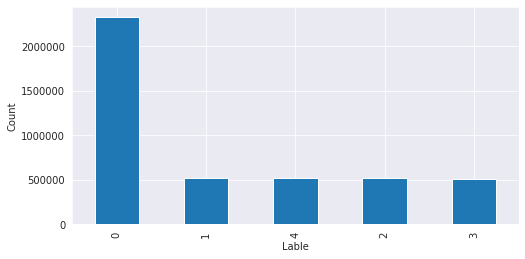

In [8]:
##Visualizing label distribution
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
trainDF["label"].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Lable')
print(trainDF["label"].value_counts())

In [9]:
trainDF.describe()

,row_id,well_id,GR,label
count,4.400000e+06,4.400000e+06,4.400000e+06,4.400000e+06
mean,5.495000e+02,1.999500e+03,9.759792e+01,1.177333e+00
std,3.175426e+02,1.154701e+03,3.206393e+01,1.464788e+00
min,0.000000e+00,0.000000e+00,1.947262e+01,0.000000e+00
25%,2.747500e+02,9.997500e+02,6.569258e+01,0.000000e+00
50%,5.495000e+02,1.999500e+03,1.075080e+02,0.000000e+00
75%,8.242500e+02,2.999250e+03,1.235464e+02,2.000000e+00
max,1.099000e+03,3.999000e+03,1.618695e+02,4.000000e+00


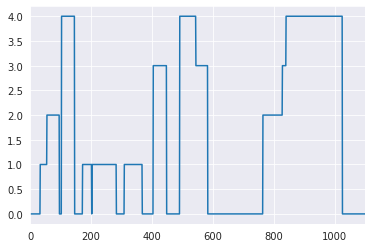

In [10]:
trainDF[trainDF.well_id==0].label.plot()

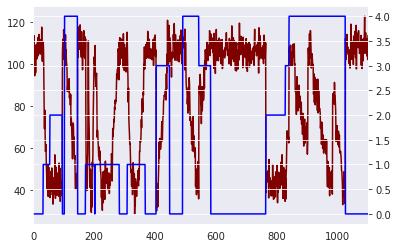

In [11]:
axl = trainDF[trainDF.well_id==0].GR.plot(color='maroon')
axr = trainDF[trainDF.well_id==0].label.plot(color='blue',secondary_y=True)

#### Building some useful functions
Smoothing/denoising functions for GR values 
Some other functions for understaing the data better


In [12]:
##some useful function to process data
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def countSimilarConsectiveNums(lst):
    resVal = []
    resCnt = []
    val = -1
    cnt = 0
    prevVal = lst[0]
    for ii in range(1,len(lst)):
        #print(lst[ii])
        val = lst[ii]
        cnt +=1
        if prevVal!=val:
            #print(prevVal,val)
            resVal.append(prevVal)
            resCnt.append(cnt)
            prevVal = val
            cnt = 0
    resVal.append(prevVal)
    resCnt.append(cnt+1)
    return (resVal, resCnt)

def countSimilarConsectiveNumsStats(lst):
    resVal = []
    resCnt = []
    val = -1
    cnt = 0
    prevVal = lst[0]
    for ii in range(1,len(lst)):
        #print(lst[ii])
        val = lst[ii]
        cnt +=1
        if prevVal!=val:
            #print(prevVal,val)
            resVal.append(prevVal)
            resCnt.append(cnt)
            prevVal = val
            cnt = 0
    resVal.append(prevVal)
    resCnt.append(cnt+1)
    res = {}
    res["resVal"] = np.array(resVal)
    res["resCnt"] = np.array(resCnt)
    res["firstLabel"] = lst[0]
    res["lastLabel"] = lst[-1]
    res["firstLabelWinSize"] = resCnt[0]
    res["lastLabelWinSize"] = resCnt[-1]
    res["minCnt"] = min(resCnt)
    res["maxCnt"] = max(resCnt)
    res["resNonZeroVal"] = np.array(resVal)[np.array(resVal)>0]
    res["resNonZeroCnt"] = np.array(resCnt)[np.array(resVal).nonzero()]
    return (res)

#countSimilarConsectiveNums([1,1,1,1,4,4,4,4,4,5,5,1,3,3,3,0,0,0,0,0])                    

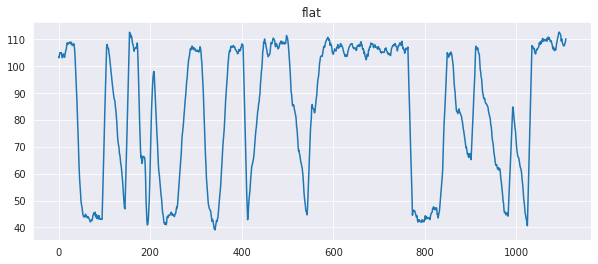

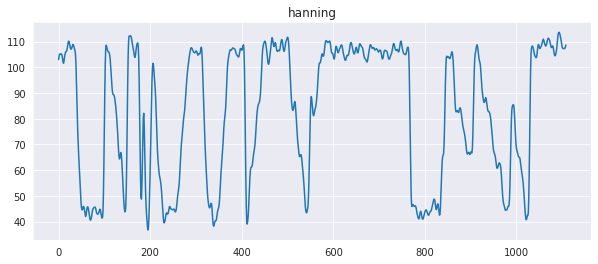

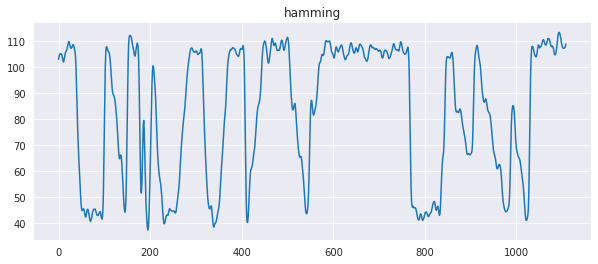

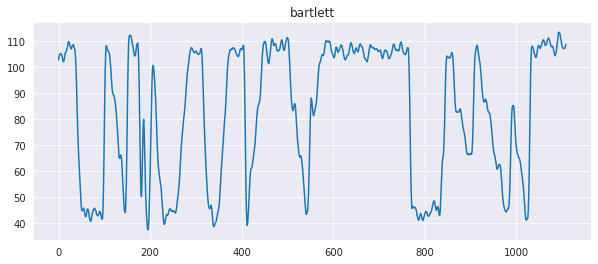

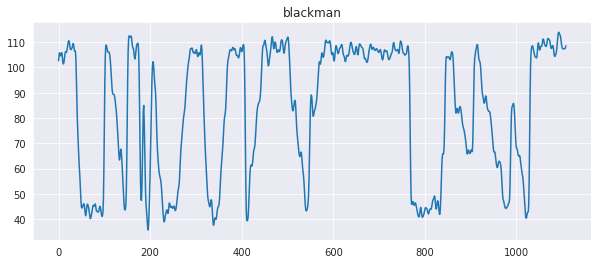

In [21]:
##smoothing the signal - finding the best windiw size
window_len=30 #windowsize
windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
#wls = [10,20,31,51,101]
wls = [10]
for wl in wls:
    for w in windows:
        plt.figure(figsize=(10,4))
        plt.plot(smooth(trainDF[trainDF.well_id==0].GR,wl,w))
        plt.title(w)
        plt.show()

flat


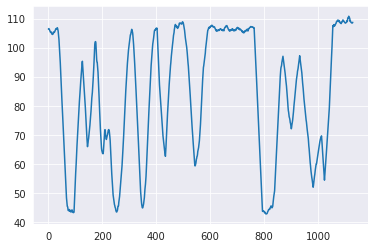

hanning


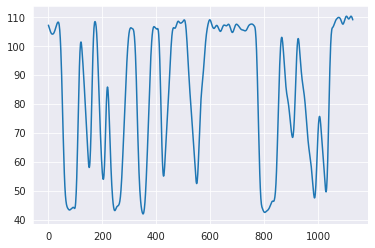

hamming


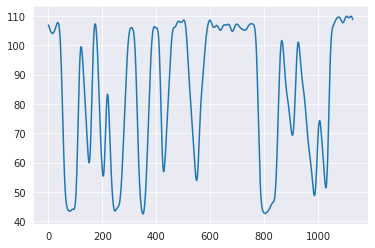

bartlett


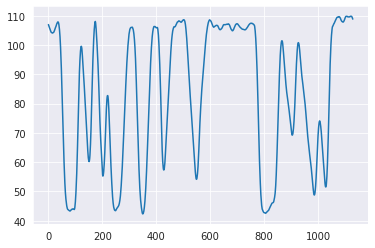

blackman


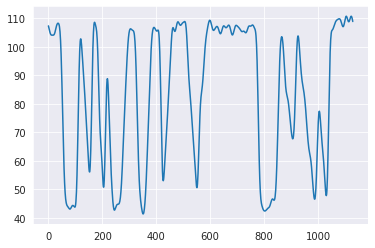

In [22]:
##smoothing the signal - finding the best algo
wl = 31
for w in windows:
    plt.plot(smooth(trainDF[trainDF.well_id==0].GR,wl,w))#hanning with window len 31 seems the best
    print(w)
    plt.show()
##seems hamming with wl=31 works the best

In [23]:
##run the functions for counting labels and their lengths on the first well
countSimilarConsectiveNums(trainDF[trainDF.well_id==0].label.tolist())

([0, 1, 2, 0, 4, 0, 1, 0, 1, 0, 1, 0, 3, 0, 4, 3, 0, 2, 3, 4, 0],
 [33,
  22,
  41,
  7,
  43,
  26,
  30,
  1,
  80,
  26,
  59,
  36,
  44,
  43,
  53,
  39,
  181,
  64,
  12,
  185,
  75])

In [13]:
##run the functions for counting labels and their lengths on the first well
countSimilarConsectiveNumsStats(trainDF[trainDF.well_id==0].label.tolist())

{'firstLabel': 0,
 'firstLabelWinSize': 33,
 'lastLabel': 0,
 'lastLabelWinSize': 75,
 'maxCnt': 185,
 'minCnt': 1,
 'resCnt': array([ 33,  22,  41,   7,  43,  26,  30,   1,  80,  26,  59,  36,  44,
         43,  53,  39, 181,  64,  12, 185,  75]),
 'resNonZeroCnt': array([ 22,  41,  43,  30,  80,  59,  44,  53,  39,  64,  12, 185]),
 'resNonZeroVal': array([1, 2, 4, 1, 1, 1, 3, 4, 3, 2, 3, 4]),
 'resVal': array([0, 1, 2, 0, 4, 0, 1, 0, 1, 0, 1, 0, 3, 0, 4, 3, 0, 2, 3, 4, 0])}

In [14]:
## Most of the first rows' GR values for wells ar 0
trainDF.groupby("well_id").first().label.value_counts()

0    3940
1      17
4      15
3      14
2      14
Name: label, dtype: int64

In [15]:
## all the last rows' GR values for wells ar 0
trainDF.groupby("well_id").last().label.value_counts()

0    4000
Name: label, dtype: int64

In [16]:
trainDF.groupby("well_id").apply(lambda x: countSimilarConsectiveNumsStats(x.label.tolist())["lastLabelWinSize"]).min()

14

In [17]:
trainDF.groupby("well_id").apply(lambda x: countSimilarConsectiveNumsStats(x.label.tolist())["resNonZeroCnt"].min())

well_id
0       12
1        2
2        9
3        9
4        9
5       11
6       10
7        5
8       12
9        6
10      17
11       3
12       8
13      11
14       1
15      10
16       1
17       2
18       5
19       9
20      12
21      15
22      13
23      10
24       5
25      11
26       4
27       1
28       8
29      12
        ..
3970     2
3971    12
3972     7
3973    22
3974     3
3975     2
3976     4
3977     7
3978     3
3979     9
3980    12
3981     5
3982     8
3983     1
3984     1
3985    11
3986    18
3987    18
3988     2
3989    11
3990    13
3991     8
3992     6
3993    15
3994     2
3995    23
3996    18
3997    16
3998     9
3999    13
Length: 4000, dtype: int64

In [18]:
np.nonzero([0, 3, 0, 1, 3, 0, 4, 1, 4, 2, 0, 2, 0, 1, 2, 1, 0, 3, 0])

(array([ 1,  3,  4,  6,  7,  8,  9, 11, 13, 14, 15, 17]),)

#### Check if there is any spatial autocorrelation in GR values. Only tested on the first well

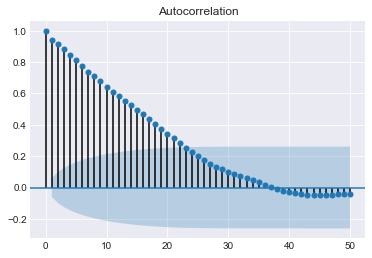

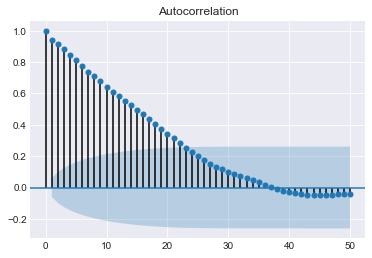

In [19]:
plot_acf(trainDF[trainDF.well_id==0].GR,lags=50)

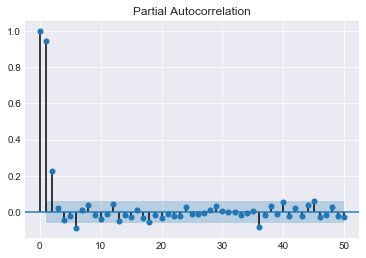

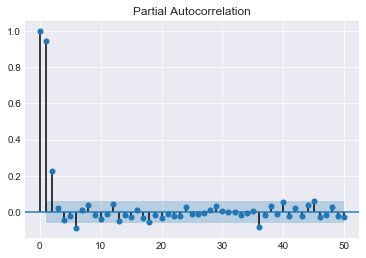

In [20]:
plot_pacf(trainDF[trainDF.well_id==0].GR,lags=
          50)

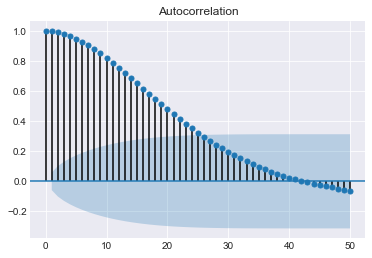

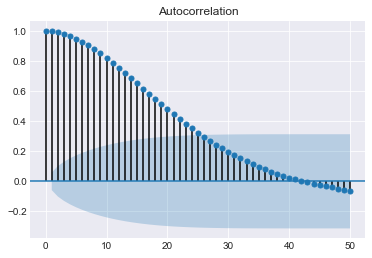

In [21]:
plot_acf(smooth(trainDF[trainDF.well_id==0].GR,31,"hanning"),lags=50)

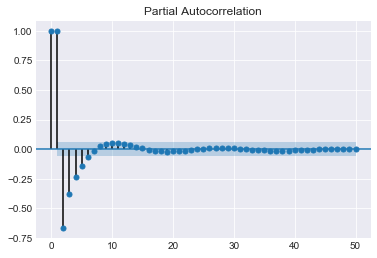

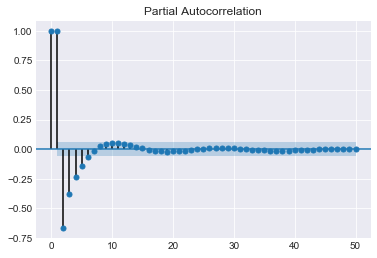

In [22]:
plot_pacf(smooth(trainDF[trainDF.well_id==0].GR,31,"hanning"),lags=50)

#### Feature engineering
By adding N (featureWinLen=5) of the GR values from before/after the current row as our extra features we can build better classifier

In [23]:
##Feature engineering. Using previous/next 5 signal values as input along with the main GR value
## This is not very correct as it will use signal values from other wells to fill the first 5 and last 5 signals - you can fix it in your own version :)
featureWinLen = 5
for ii in range(1,featureWinLen+1):
    trainDF["GR"+str(ii)] = trainDF["GR"].shift(ii)
    trainDF["GR"+str(ii)].fillna(trainDF.GR, inplace=True)
    trainDF["GR"+str(-ii)] = trainDF["GR"].shift(-ii)
    trainDF["GR"+str(-ii)].fillna(trainDF.GR, inplace=True)
display(trainDF.head())
display(trainDF.tail())

,row_id,well_id,GR,label,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,GR-4,GR5,GR-5
0,0,0,99.005617,0,99.005617,105.563944,99.005617,105.921065,99.005617,113.513354,99.005617,101.523783,99.005617,94.464482
1,1,0,105.563944,0,99.005617,105.921065,105.563944,113.513354,105.563944,101.523783,105.563944,94.464482,105.563944,103.864994
2,2,0,105.921065,0,105.563944,113.513354,99.005617,101.523783,105.921065,94.464482,105.921065,103.864994,105.921065,104.410065
3,3,0,113.513354,0,105.921065,101.523783,105.563944,94.464482,99.005617,103.864994,113.513354,104.410065,113.513354,95.934506
4,4,0,101.523783,0,113.513354,94.464482,105.921065,103.864994,105.563944,104.410065,99.005617,95.934506,101.523783,107.290773


,row_id,well_id,GR,label,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,GR-4,GR5,GR-5
4399995,1095,3999,123.022784,0,122.168365,117.469155,113.466655,118.927403,122.826384,127.449713,120.393799,126.537612,115.948916,123.022784
4399996,1096,3999,117.469155,0,123.022784,118.927403,122.168365,127.449713,113.466655,126.537612,122.826384,117.469155,120.393799,117.469155
4399997,1097,3999,118.927403,0,117.469155,127.449713,123.022784,126.537612,122.168365,118.927403,113.466655,118.927403,122.826384,118.927403
4399998,1098,3999,127.449713,0,118.927403,126.537612,117.469155,127.449713,123.022784,127.449713,122.168365,127.449713,113.466655,127.449713
4399999,1099,3999,126.537612,0,127.449713,126.537612,118.927403,126.537612,117.469155,126.537612,123.022784,126.537612,122.168365,126.537612


In [24]:
##Build the data set for training and test -- for simplicity we use first 100000 rows as our training data set and 
##the second 100000 as validation
trainDataSet_X = trainDF.loc[:100000,:].drop(["row_id","well_id","label"],1)
trainDataSet_Y = trainDF.loc[:100000,"label"]
valDataSet_X = trainDF.loc[100000:200000,:].drop(["row_id","well_id","label"],1)
valDataSet_Y = trainDF.loc[100000:200000,"label"]

In [25]:
display(trainDataSet_X.head())
print(trainDataSet_X.shape,trainDataSet_Y.shape,valDataSet_X.shape,valDataSet_Y.shape)

,GR,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,GR-4,GR5,GR-5
0,99.005617,99.005617,105.563944,99.005617,105.921065,99.005617,113.513354,99.005617,101.523783,99.005617,94.464482
1,105.563944,99.005617,105.921065,105.563944,113.513354,105.563944,101.523783,105.563944,94.464482,105.563944,103.864994
2,105.921065,105.563944,113.513354,99.005617,101.523783,105.921065,94.464482,105.921065,103.864994,105.921065,104.410065
3,113.513354,105.921065,101.523783,105.563944,94.464482,99.005617,103.864994,113.513354,104.410065,113.513354,95.934506
4,101.523783,113.513354,94.464482,105.921065,103.864994,105.563944,104.410065,99.005617,95.934506,101.523783,107.290773


(100001, 11) (100001,) (100001, 11) (100001,)


In [26]:
##Build a classifier
my_model = GradientBoostingClassifier(random_state=37)
my_model.fit(trainDataSet_X, trainDataSet_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=37,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [27]:
#run some test on validation test
val_result = my_model.predict(valDataSet_X)

In [28]:
##create some evaluation methods
def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pn.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [29]:
##evaluate the performance
evaluation_result = Evaluate(actual = valDataSet_Y,
                                 predicted = val_result,
                                 labels = [0, 1, 2, 3, 4])
display(evaluation_result)

Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[52982    71     0   217   319]
 [  599  3212  3815  2852  1745]
 [    0   565 10772   185   217]
 [ 2675  1057  1387  5716   801]
 [ 2465   654  1119   350  6226]]


,0,1,2,3,4
accuracy,0.789072,0.789072,0.789072,0.789072,0.789072
precision,0.902267,0.577802,0.630199,0.613305,0.668887
recall,0.988673,0.262783,0.917625,0.491234,0.575735
F1,0.943496,0.361264,0.747225,0.545524,0.618825
macro precision,0.678492,0.678492,0.678492,0.678492,0.678492
macro recall,0.647210,0.647210,0.647210,0.647210,0.647210
macro F1,0.643267,0.643267,0.643267,0.643267,0.643267
average accuracy,0.915629,0.915629,0.915629,0.915629,0.915629
micro-averaged precision/recall/F1,0.789072,0.789072,0.789072,0.789072,0.789072
majority class accuracy,0.535885,0.000000,0.000000,0.000000,0.000000


#### Prepare the test set for submision

In [30]:
##first step feature engieering
#featureWinLen is set from training phase
for ii in range(1,featureWinLen+1):
    testDF["GR"+str(ii)] = testDF["GR"].shift(ii)
    testDF["GR"+str(ii)].fillna(trainDF.GR, inplace=True)
    testDF["GR"+str(-ii)] = testDF["GR"].shift(-ii)
    testDF["GR"+str(-ii)].fillna(testDF.GR, inplace=True)
display(testDF.head())
display(testDF.tail())

,row_id,well_id,GR,label,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,GR-4,GR5,GR-5
0,0,5000,134.943504,0,99.005617,127.004675,99.005617,133.159255,99.005617,134.411762,99.005617,135.748644,99.005617,124.695214
1,1,5000,127.004675,0,134.943504,133.159255,105.563944,134.411762,105.563944,135.748644,105.563944,124.695214,105.563944,141.253217
2,2,5000,133.159255,0,127.004675,134.411762,134.943504,135.748644,105.921065,124.695214,105.921065,141.253217,105.921065,137.763622
3,3,5000,134.411762,0,133.159255,135.748644,127.004675,124.695214,134.943504,141.253217,113.513354,137.763622,113.513354,131.665785
4,4,5000,135.748644,0,134.411762,124.695214,133.159255,141.253217,127.004675,137.763622,134.943504,131.665785,101.523783,140.515328


,row_id,well_id,GR,label,GR1,GR-1,GR2,GR-2,GR3,GR-3,GR4,GR-4,GR5,GR-5
384995,1095,5349,134.221769,0,127.480840,135.804491,125.349253,126.124399,120.417465,117.591583,131.035860,132.555150,137.706822,134.221769
384996,1096,5349,135.804491,0,134.221769,126.124399,127.480840,117.591583,125.349253,132.555150,120.417465,135.804491,131.035860,135.804491
384997,1097,5349,126.124399,0,135.804491,117.591583,134.221769,132.555150,127.480840,126.124399,125.349253,126.124399,120.417465,126.124399
384998,1098,5349,117.591583,0,126.124399,132.555150,135.804491,117.591583,134.221769,117.591583,127.480840,117.591583,125.349253,117.591583
384999,1099,5349,132.555150,0,117.591583,132.555150,126.124399,132.555150,135.804491,132.555150,134.221769,132.555150,127.480840,132.555150


In [31]:
testDataSet_X = testDF.drop(["row_id","well_id","label"],1)

In [32]:
#run the classifier trained by our training data set on the public test set
test_result = my_model.predict(testDataSet_X)

In [33]:
yy = np.bincount(test_result)
nn = np.nonzero(yy)[0]
print("Results from classifier: ")
display(np.vstack((nn,yy[nn])).T )
print("Actual labels: ")
display(testDF.label.value_counts() )

Results from classifier: 


array([[     0, 222785],
       [     1,  21659],
       [     2,  66095],
       [     3,  35534],
       [     4,  38927]])

Actual labels: 


0    201493
4     47202
3     45926
2     45358
1     45021
Name: label, dtype: int64

#### Generate submission file
Please do not change the format(columns)/path and file name for final submission.
For leaderboard you only need to submit sumbission.csv file but for final submission you need to submit your final notebook.

In [34]:
testDF["PredictedLabel"] = test_result
testDF[["row_id","well_id","PredictedLabel"]].to_csv("submission.csv")